In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from qiskit_machine_learning.algorithms import QSVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.visualization import plot_circuit_layout
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit.library import BlueprintCircuit
from qiskit.circuit import Parameter
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

In [5]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
    scaler = StandardScaler()
    iris = load_iris()
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

**Classical SVM**

Without PCA

In [7]:
features = []
accuracies = []

for i in range(2,5):
    svm = SVC(kernel='rbf', C=i)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    features.append(i)  
    accuracies.append(accuracy)  
    print(f"Feature {i}: Accuracy = {accuracy}")
    

Feature 2: Accuracy = 1.0
Feature 3: Accuracy = 1.0
Feature 4: Accuracy = 1.0


With PCA

In [9]:
features = []
accuracies = []

for i in range(2,5):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    svm = SVC(kernel='rbf', C=i)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    features.append(i)  
    accuracies.append(accuracy)  
    print(f"Feature {i}: Accuracy = {accuracy}")
    

Feature 2: Accuracy = 0.9666666666666667
Feature 3: Accuracy = 1.0
Feature 4: Accuracy = 1.0


**QSVM**

In [33]:


def train_qsvm_with_Iris(quantum_circuit):
    
    if quantum_circuit.num_qubits < len(quantum_circuit.parameters):
            print(f"Qubits {quantum_circuit.num_qubits} < Parameters {len(quantum_circuit.parameters)}")
    elif quantum_circuit.num_qubits == len(quantum_circuit.parameters):
            print(f"Qubits {quantum_circuit.num_qubits} = Parameters {len(quantum_circuit.parameters)}")
    else:
            print(f"Qubits {quantum_circuit.num_qubits} > Parameters {len(quantum_circuit.parameters)}")
            
            

    if len(quantum_circuit.parameters) != X_train.shape[1]:
        pca =PCA(n_components=len(quantum_circuit.parameters)) # PCA đến parameters
        X_training = pca.fit_transform(X_train)
        X_testing = pca.transform(X_test)
    else:
        X_training = X_train
        X_testing = X_test


    backend = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=quantum_circuit, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_training, y_train)
    y_pred = qsvc.predict(X_testing)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


In [20]:
import os
from qiskit.qpy import load

In [ ]:
base_directory = r'C:\Desktop\GA+QSVM'
folder_pattern = "[IRIS]Best_Circuit_With_NumQubit_{i}_Depth_{j}_NumCircuit_{k}"
results = {}
GAfeatures = []
GAccuracies = []


for i in range(1,9):
    for j in range(1,9):
        for k in range(1,9):
            folder_name = folder_pattern.format(i=i, j=j, k=k)
            folder_path = os.path.join(base_directory, folder_name)
            
            if os.path.isdir(folder_path):
                file_path = os.path.join(folder_path, "best_circuit.qpy")
                
                if os.path.exists(file_path):
                    try:
                        with open(file_path, "rb") as f:
                            circuits = load(f) 
                            best_circuit = circuits[0]  
                            
                            if len(best_circuit.parameters) == X_train.shape[1] and len(best_circuit.parameters) > 1:
                                test = train_qsvm_with_Iris(best_circuit)
                                print(f"Accuracy: {test}")
                                GAfeatures.append(len(best_circuit.parameters))  
                                GAccuracies.append(test)  

                    
                    except Exception as e:
                        print(f"Error loading circuit in {file_path}: {e}") 
                else:
                    print("Fail loading")

Qubits 4 > Parameters 2
Accuracy: 0.8666666666666667
Qubits 4 > Parameters 2
Accuracy: 0.43333333333333335
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 > Parameters 3
Accuracy: 0.9666666666666667
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 = Parameters 4
Accuracy: 1.0
Qubits 4 = Parameters 4
Accuracy: 0.9
Qubits 4 = Parameters 4
Accuracy: 1.0


In [44]:
def sort_and_deduplicate(features, accuracies):


    combined = list(zip(features, accuracies))
    

    feature_to_accuracy = {}
    for feature, accuracy in combined:
        if feature not in feature_to_accuracy:
            feature_to_accuracy[feature] = accuracy
        else:

            feature_to_accuracy[feature] = max(feature_to_accuracy[feature], accuracy)
    

    deduplicated_features = sorted(feature_to_accuracy.keys())
    deduplicated_accuracies = [feature_to_accuracy[feature] for feature in deduplicated_features]
    
    return deduplicated_features, deduplicated_accuracies


deduplicated_features, deduplicated_accuracies = sort_and_deduplicate(GAfeatures, GAccuracies)

print("Features:", deduplicated_features)
print("Accuracies:", deduplicated_accuracies)


Features: [2, 3, 4]
Accuracies: [0.8666666666666667, 0.9666666666666667, 1.0]


**ZFeatureMap()**

In [45]:
zfeatures = []
zaccuracies = []

for i in range(2, 5):
    feature_map = ZFeatureMap(feature_dimension=i)
    test = train_qsvm_with_Iris(feature_map)
    zfeatures.append(i)  
    zaccuracies.append(test)  
    print(f"Feature {i}: {test}")

Qubits 2 = Parameters 2
Feature 2: 0.6666666666666666
Qubits 3 = Parameters 3
Feature 3: 0.6333333333333333
Qubits 4 = Parameters 4
Feature 4: 0.9333333333333333


**ZZFeatureMap()**

In [42]:
zzfeatures = []
zzaccuracies = []

for i in range(2, 5):
    feature_map = ZZFeatureMap(feature_dimension=i)
    test = train_qsvm_with_Iris(feature_map)
    zzfeatures.append(i)  
    zzaccuracies.append(test)  
    print(f"Feature {i}: {test}")

Qubits 2 = Parameters 2
Feature 2: 0.5666666666666667
Qubits 3 = Parameters 3
Feature 3: 0.6
Qubits 4 = Parameters 4
Feature 4: 0.7666666666666667


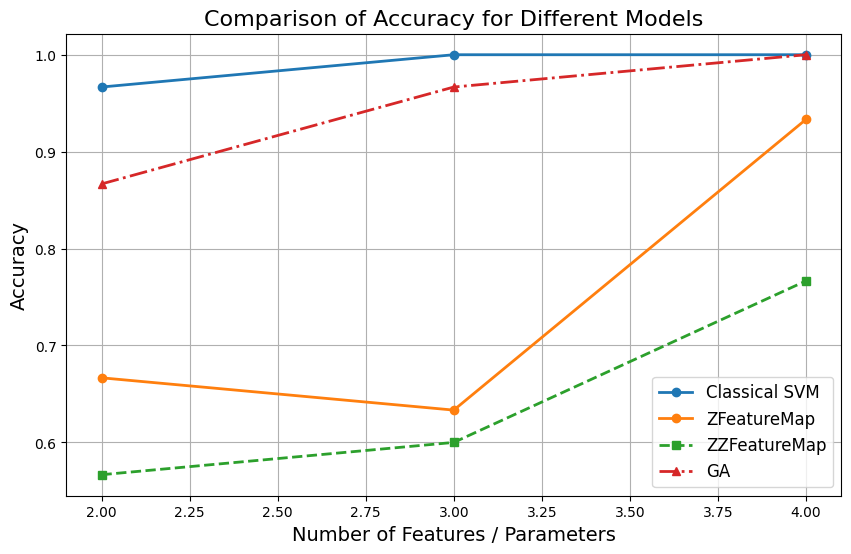

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.plot(features, accuracies, marker='o', linestyle='-', label='Classical SVM', linewidth=2)


plt.plot(zfeatures, zaccuracies, marker='o', linestyle='-', label='ZFeatureMap', linewidth=2)


plt.plot(zzfeatures, zzaccuracies, marker='s', linestyle='--', label='ZZFeatureMap', linewidth=2)

plt.plot(deduplicated_features, deduplicated_accuracies, marker='^', linestyle='-.', label='GA', linewidth=2)


plt.title("Comparison of Accuracy for Different Models", fontsize=16)
plt.xlabel("Number of Features / Parameters", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)


plt.show()
